<a href="https://colab.research.google.com/github/elisabethelen/T3-DeepLearning/blob/main/Multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://youtu.be/hraKTseOuJA

"""
Dataset from here: https://www.kaggle.com/datasets/elisabethbupu/datasetmultilabel-202255202026
"""

'\nDataset from here: https://www.kaggle.com/datasets/elisabethbupu/datasetmultilabel-202255202026\n'

In [2]:
!pip install -q kaggle

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization

In [4]:
#image_directory = 'DatasetMultilable_AnisahFitriani_202255202069/DatasetMultilable_AnisahFitriani_202255202069/'

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("elisabethbupu/datasetmultilabel-202255202026")

#print("Path to dataset files:", path)

In [5]:
{
  "username": "ElisabethBupu",
  "key": "cb1711c8d3cdf20xb004c6c124a3cd9"
}

{'username': 'ElisabethBupu', 'key': 'cb1711c8d3cdf20xb004c6c124a3cd9'}

In [6]:
import os
os.environ["KAGGLE_USERNAME"] = "ElisabethBupu" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "cb1711c8d3cdf20xb004c6c124a3cd9" # Ganti dengan key yang ada di kaggle.json

In [7]:

!kaggle datasets download -d elisabethbupu/datasetmultilabel-202255202026

Dataset URL: https://www.kaggle.com/datasets/elisabethbupu/datasetmultilabel-202255202026
License(s): CC0-1.0
 97% 1.11G/1.14G [00:08<00:00, 251MB/s]
100% 1.14G/1.14G [00:09<00:00, 135MB/s]


In [8]:
# prompt: unzip file datasetmultilabel-202255202026.zip

!unzip datasetmultilabel-202255202026.zip

Archive:  datasetmultilabel-202255202026.zip
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 001.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 002.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 003.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 004.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 005.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 006.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 007.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 008.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 009.jpg  
  inflating: DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 010.jpg  
  inflating: DatasetMultilable/Data

In [9]:
#Now let us read metadata to get our Y values (multiple lables)
# Try reading with semicolon as delimiter
try:
    df = pd.read_csv('/content/DatasetMultilable/traindataset_ElisabethBupu_202255202026.csv', sep=';')
    print("Read with semicolon delimiter successful.")
except pd.errors.ParserError: # Changed to pd.errors.ParserError for clarity
    print("Reading with semicolon delimiter failed. Trying default comma delimiter (might still fail).")
    df = pd.read_csv('/content/DatasetMultilable/traindataset_ElisabethBupu_202255202026.csv')

print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:2000].reset_index(drop=True)  #Loading only first 2000 datapoints and reset the index
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to
#the metadata from the csv file.

Read with semicolon delimiter successful.
          id  jenis barang  laptop  buku  tempat pensil botol,,,
0  el2025001  laptop,buku        1     1              0      0,,
1  el2025002  laptop,buku        1     1              0      0,,
2  el2025003  laptop,buku        1     1              0      0,,
3  el2025004  laptop,buku        1     1              0      0,,
4  el2025005  laptop,buku        1     1              0      0,,
Index(['id', 'jenis barang', 'laptop', 'buku', 'tempat pensil', 'botol,,,'], dtype='object')


In [19]:
!ls /content/DatasetMultilable/

DatasetMultilabe_ElisabethBupu_202255202026
traindataset_ElisabethBupu_202255202026.csv


In [20]:
!ls {image_directory} | head -n 20

/content/DatasetMultilable/traindataset_ElisabethBupu_202255202026.csv


In [29]:
SIZE = 200
X_dataset = []
#Define image_directory before it's used in the loop
image_directory = '/content/DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026' # Change to extracted image directory

# Print the column names to verify the correct identifier column
print(df.columns)

# --- Modifikasi pada loop pemuatan gambar ---
X_dataset = []
loaded_image_ids = [] # Daftar untuk melacak ID gambar yang berhasil dimuat
loaded_df_indices = [] # Daftar untuk menyimpan indeks baris dari df yang berhasil dimuat gambarnya

for i in tqdm(range(df.shape[0])):
    # Ambil ID dari dataframe
    df_id = str(df['id'][i])

    # *** Modifikasi di sini: Ekstrak bagian nomor dari ID dan format nama file ***
    # Asumsikan ID di dataframe selalu memiliki format 'elXXXXXX'
    # Kita perlu mengambil 3 digit terakhir dan memformatnya menjadi '001', '002', dst.
    try:
        # Coba ekstrak nomor dari ID
        # Anda mungkin perlu menyesuaikan cara ekstraksi ini tergantung format ID sebenarnya
        # Misalnya, jika ID selalu 'el' diikuti 6 digit, kita ambil 3 digit terakhir
        # Misalnya 'el2025001', ambil '001'
        nomor_str = df_id[-3:] # Ambil 3 karakter terakhir dari string ID

        # Format nama file sesuai dengan format di direktori gambar
        # Pastikan nomornya memiliki leading zeros jika perlu (misalnya '001', bukan '1')
        # Berdasarkan output ls, formatnya 'Gambar XXX.jpg' di mana XXX adalah 3 digit
        img_filename = f"Gambar {nomor_str}.jpg" # Gunakan f-string untuk format yang mudah

        img_path = os.path.join(image_directory, img_filename)

        # Tambahkan blok try-except yang sama untuk menangani error
        try:
            img = image.load_img(img_path, target_size=(SIZE,SIZE,3))
            img = image.img_to_array(img)
            img = img/255.
            X_dataset.append(img)
            loaded_image_ids.append(df_id) # Tambahkan ID ke daftar jika load berhasil
            loaded_df_indices.append(i) # Tambahkan indeks baris ke daftar jika load berhasil
        except FileNotFoundError:
            # Jika file tidak ditemukan, cetak peringatan dan lanjutkan ke iterasi berikutnya
            print(f"Warning: File not found for formatted ID '{df_id}' searching for path {img_path}. Skipping this image.")
        except Exception as e:
            # Tangkap error potensial lainnya selama pemuatan gambar
            print(f"Warning: Error loading image for formatted ID '{df_id}' at path {img_path}: {e}. Skipping this image.")

    except Exception as e:
        # Tangkap error jika ada masalah saat mengekstrak nomor dari ID dataframe
        print(f"Error processing ID '{df_id}': {e}. Skipping this entry.")


# --- Kode setelah loop (cek dan konversi ke numpy array) tetap sama ---
print(f"\nSuccessfully loaded {len(X_dataset)} images out of {df.shape[0]} entries in the dataframe.")
if len(X_dataset) == 0:
    print("Error: No images were loaded. Please verify the image_directory path and the logic for generating image filenames.")
    # Jika tidak ada gambar yang dimuat, kita tidak bisa melanjutkan, jadi keluar atau berikan pesan error
    raise ValueError("No images were loaded. Cannot proceed.")
else:
    # Konversi X_dataset menjadi numpy array
    X = np.array(X_dataset)

    # Memfilter dataframe agar sesuai dengan gambar yang berhasil dimuat
    df_loaded = df.iloc[loaded_df_indices].reset_index(drop=True)

    print(f"Shape of X after loading: {X.shape}")
    print(f"Shape of filtered df: {df_loaded.shape}")
# --- Akhir modifikasi ---

X = np.array(X_dataset)

Index(['id', 'jenis barang', 'laptop', 'buku', 'tempat pensil', 'botol,,,'], dtype='object')


100%|██████████| 300/300 [00:51<00:00,  5.82it/s]



Successfully loaded 300 images out of 300 entries in the dataframe.
Shape of X after loading: (300, 200, 200, 3)
Shape of filtered df: (300, 6)


In [30]:
#
print(df['id'][7])  #King Kong

el2025008


In [31]:
print(df['jenis barang'][7])

laptop,buku 


In [37]:
# *** Memfilter dataframe agar sesuai dengan gambar yang berhasil dimuat ***
# Buat dataframe baru yang hanya berisi baris-baris yang gambarnya berhasil dimuat
# Ini SANGAT PENTING karena X hanya berisi data gambar yang berhasil dimuat,
# jadi y harus sesuai dengan baris-baris tersebut.
df_loaded = df.iloc[loaded_df_indices].reset_index(drop=True)

print(f"Shape of X after loading: {X.shape}")
print(f"Shape of filtered df: {df_loaded.shape}")

# --- Modifikasi di sini ---
# Identifikasi kolom label. Asumsikan semua kolom setelah 'id' dan 'jenis barang'
# adalah kolom label. Sesuaikan jika struktur kolom berbeda.
label_columns = df_loaded.columns.drop(['id', 'jenis barang'])

# Pilih hanya kolom label and inspect some values before conversion
print("Inspecting first 10 rows of label columns before conversion:")
print(df_loaded[label_columns].head(10))
print("\nUnique values in each label column before conversion:")
for col in label_columns:
    print(f"Column '{col}': {df_loaded[col].unique()}")


# Before converting to int, replace known problematic string values
# Based on the error, '0,,' is a problematic value. Replace it with 0.
# You might need to add more replacements if other invalid strings are found.
for col in label_columns:
    if df_loaded[col].dtype == 'object': # Check if column is object type (likely contains mixed types including strings)
        print(f"Attempting to clean column: {col}")
        # Use .str.replace to handle potential string values, handle NaNs, and replace problematic strings
        # The regex=False is important to treat '0,,' as a literal string
        df_loaded[col] = df_loaded[col].astype(str).str.replace('0,,', '0', regex=False)
        # Now try converting to numeric, coercing errors to NaN
        df_loaded[col] = pd.to_numeric(df_loaded[col], errors='coerce')
        # Fill any NaNs introduced by coercion (or original NaNs) with a default value, e.g., 0
        df_loaded[col] = df_loaded[col].fillna(0)
        print(f"Finished cleaning column: {col}")


# Now, convert the cleaned label columns to integer
try:
    y = np.array(df_loaded[label_columns].astype(int))
    print("Label columns successfully converted to integer.")
except ValueError as e:
    print(f"Error converting label columns to integer AFTER cleaning attempt: {e}")
    print("Please check the content of the label columns in df_loaded. Even after cleaning, they might contain non-integer values.")
    print("First few rows of label columns AFTER cleaning attempt:")
    print(df_loaded[label_columns].head())
    raise # Re-raise the error after printing info


print(f"Shape of y after filtering and casting: {y.shape}")
print(f"Data type of y: {y.dtype}") # Print dtype to verify

# Periksa sebelum splitting
if X.shape[0] != y.shape[0]:
    # Seharusnya tidak terjadi jika df_loaded dibuat dengan benar
    print(f"Error: Mismatch in sample count between X ({X.shape[0]}) and y ({y.shape[0]}). Cannot split.")
    # Ini seharusnya tertangkap oleh cek sebelumnya if len(X_dataset) == 0,
    # tetapi ini adalah perlindungan tambahan
    raise ValueError("Sample count mismatch between X and y after processing.")
elif X.shape[0] == 0:
     # Ini seharusnya tertangkap oleh cek sebelumnya if len(X_dataset) == 0
     # Biarkan ValueError asli dari cek sebelumnya yang terpicu
     pass # Lewati cek ini karena sudah ditangani sebelumnya
else:
    print("X and y shapes match and are not empty. Proceeding with train_test_split.")
    # Lakukan pemisahan data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)
    print("Data split successfully.")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

Shape of X after loading: (300, 200, 200, 3)
Shape of filtered df: (300, 6)
Inspecting first 10 rows of label columns before conversion:
   laptop  buku  tempat pensil botol,,,
0       1     1              0      0,,
1       1     1              0      0,,
2       1     1              0      0,,
3       1     1              0      0,,
4       1     1              0      0,,
5       1     1              0      0,,
6       1     1              0      0,,
7       1     1              0      0,,
8       1     1              0      0,,
9       1     1              0      0,,

Unique values in each label column before conversion:
Column 'laptop': [1 0]
Column 'buku': [1 0]
Column 'tempat pensil': [0 1]
Column 'botol,,,': ['0,,' '1,,' '0,' '1,' '1']
Attempting to clean column: botol,,,
Finished cleaning column: botol,,,
Label columns successfully converted to integer.
Shape of y after filtering and casting: (300, 4)
Data type of y: int64
X and y shapes match and are not empty. Proceeding with

In [41]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# Change the number of units in the final Dense layer from 5 to 4
model.add(Dense(4, activation='sigmoid'))

#Do not use softmax for multilabel classification
#Softmax is useful for mutually exclusive classes, either cat or dog but not both.
#Also, softmax outputs all add to 1. So good for multi class problems where each
#class is given a probability and all add to 1. Highest one wins.

#Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
#like multi label, in this example.
#But, also good for binary mutually exclusive (cat or not cat).

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 196, 196, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 196, 196, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 94, 94, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 43, 43, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 17, 17, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,412 (2.68 MB)

 Trainable params: 701,060 (2.67 MB)

 Non-trainable params: 352 (1.38 KB)

In [42]:
#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5758 - loss: 0.0526 - val_accuracy: 0.3333 - val_loss: 2.2332
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6344 - loss: 0.0672 - val_accuracy: 0.3444 - val_loss: 2.1550
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6805 - loss: 0.0456 - val_accuracy: 0.3222 - val_loss: 2.4186
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7057 - loss: 0.0550 - val_accuracy: 0.3222 - val_loss: 1.9992
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5860 - loss: 0.0709 - val_accuracy: 0.2889 - val_loss: 1.5019
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7550 - loss: 0.0586 - val_accuracy: 0.3556 - val_loss: 1.5470
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7318 - loss: 0.0829 - val_accuracy: 0.4000 - val_loss: 1.8454
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6837 - loss: 0.0679 - val_accuracy: 0.4222 - val_loss: 1.5932


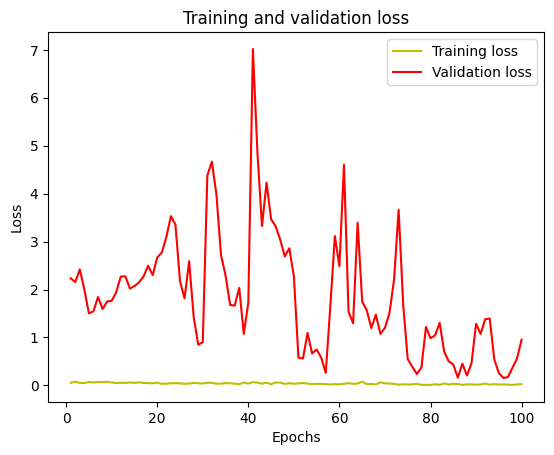

In [51]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

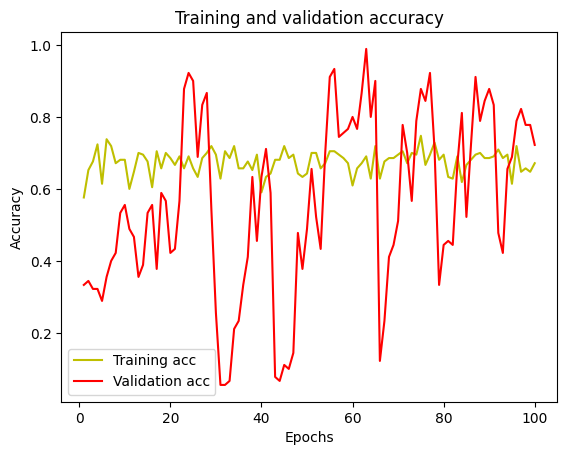

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


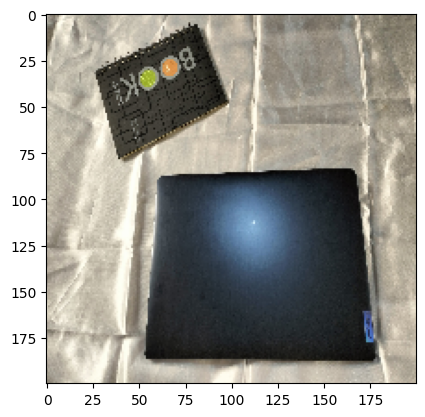

In [53]:
#Validate on an image
#img = image.load_img('/content/Multi_Label_dataset/Images/tt0085318.jpg', target_size=(SIZE,SIZE,3))
# Assuming 'ddlj.jpg' is in '/content/Multi_Label_dataset/Images/'
img = image.load_img('/content/DatasetMultilable/DatasetMultilabe_ElisabethBupu_202255202026/Gambar 003.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

In [54]:
#Print classes and corresponding probabilities
# Iterate up to the number of available classes
for i in range(len(classes)):
    # Access elements using the sorted indices
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

laptop (1.0)
buku (1.0)
tempat pensil (2.72e-08)
botol,,, (6.57e-10)


In [55]:
###################################################

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

################################################################

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.7166 - loss: 0.9404
Accuracy =  72.22222089767456 %


In [56]:
# prompt: berikan code evaluasi model

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels (e.g., using a threshold)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold

# Calculate and print the classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))


# Calculate and print the confusion matrix (optional)
# Note: Confusion matrices are best visualized for binary or few-class problems
# For multi-label, confusion matrix for each label is more informative
for i in range(len(classes)):
  print(f"Confusion Matrix for {classes[i]}:")
  print(confusion_matrix(y_test[:,i], y_pred_classes[:,i]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step
               precision    recall  f1-score   support

       laptop       1.00      0.84      0.91        67
         buku       0.95      0.89      0.92        66
tempat pensil       0.96      0.70      0.81        70
     botol,,,       1.00      0.12      0.22        32

    micro avg       0.97      0.71      0.82       235
    macro avg       0.98      0.64      0.72       235
 weighted avg       0.97      0.71      0.79       235
  samples avg       0.97      0.79      0.84       235

Confusion Matrix for laptop:
[[23  0]
 [11 56]]
Confusion Matrix for buku:
[[21  3]
 [ 7 59]]
Confusion Matrix for tempat pensil:
[[18  2]
 [21 49]]
Confusion Matrix for botol,,,:
[[58  0]
 [28  4]]
